In [1]:
# Imports
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from random import seed, randrange
from scipy.stats import multivariate_normal

In [2]:
# Load and Downsample Image
from PIL import Image

basewidth = 400
img = Image.open('/Users/meuli/Desktop/ML/EECE5644/HW4/elephant_color.jpg')
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), Image.ANTIALIAS)
img.save('/Users/meuli/Desktop/ML/EECE5644/HW4/resized__elephant_image.jpg')

# Load Image
img = load_img('/Users/meuli/Desktop/ML/EECE5644/HW4/resized__elephant_image.jpg')
i_array = img_to_array(img)
print(i_array.shape)

(266, 400, 3)


In [3]:
# Create 5-dimensional unit-hypercube of features (Row, Column, R, G, B)
hypercube = np.zeros((i_array.shape[0]*i_array.shape[1],5))
index = 0
for i in range(i_array.shape[0]):
    for j in range(i_array.shape[1]):
        hypercube[index,0] = i # Row Index
        hypercube[index,1] = j # Column Index
        for rgb in range(3):
            hypercube[index,rgb+2] = i_array[i,j,rgb] # RGB
        index += 1
# Normalize each feature entry
hypercube = normalize(hypercube,axis=0,norm='max')

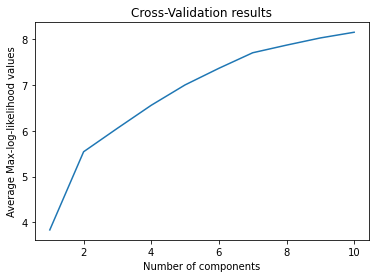

In [4]:
# Fit GMM and use 10-fold CV
f = [] # cross-val results
cv = KFold(n_splits=10, shuffle=True)
X_train = hypercube
for m in range(1,11): # model-order from 1-10
    ml = []
    for fold, (train_indices, valid_indices) in enumerate(cv.split(X_train)):
        X_train_k = X_train[train_indices]
        X_valid_k = X_train[valid_indices]
        
        model = GaussianMixture(n_components= m,init_params='kmeans', max_iter=300)
        model.fit(X_train_k)

        # Compute per-sample average log-likelihood score
        ml.append(model.score(X_valid_k))
    # append the mean LL score from all folds
    f.append(np.mean(ml))

# Plot Cross Val Scores
plt.plot(range(1,11), f)
plt.xlabel("Number of components")
plt.ylabel("Average Max-log-likelihood values")
plt.title("Cross-Validation results")
plt.show()

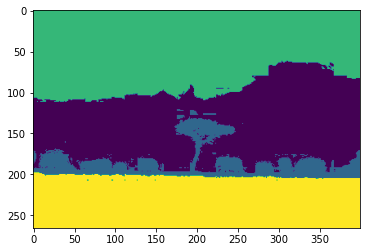

In [5]:
# Identified best GMM num components as 4
model = GaussianMixture(n_components= 4,init_params='kmeans', max_iter=300)
model.fit(hypercube)

final_results = np.zeros((i_array.shape[0]*i_array.shape[1],model.n_components))

for i in range(model.n_components):
    pdf = multivariate_normal.pdf(hypercube, mean=model.means_[i,:],cov=model.covariances_[i,:,:])
    final_results[:,i] = np.array(model.weights_[i]*pdf)
final_results = np.argmax(final_results, axis=1)

plt.imshow(final_results.reshape(i_array.shape[0],i_array.shape[1]))
plt.show()




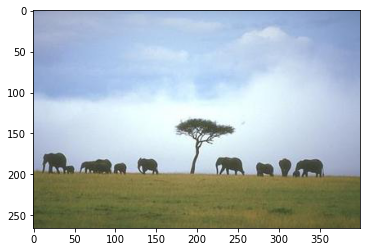

In [6]:
plt.imshow(img)
